# Obtaining the data from the Mona File

## Getting the path for Mona file

Using the method load_from_msp, the information inside the Mona file is being obtained.

In [1]:
import os
import sys

ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)

In [4]:
from custom_functions.spectra_functions import get_data_folder_path

path = get_data_folder_path()
path

'/Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data'

In [5]:
import matplotlib.pyplot as plt

def plot_similarity_algorithms_performance(show_top_percentile, percentile_cosine_nist, 
                                           percentile_cosine_massbank, percentile_cosine_demuth, 
                                           percentile_cosine_spec2vec, title=None):
    ## Code inspired by Florian Huber's jupyter notebook to plot a graph comparing all similarity meaasures
    ## https://github.com/iomega/spec2vec_gnps_data_analysis/blob/master/notebooks/iomega-7-compare-the-different-scores.ipynb
    
    num_bins = 1000

    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(7,6))

    x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]

    plt.plot(x_percentiles, percentile_cosine_nist,
             color="black", label="1) Cosine Greedy - NIST")
    plt.plot(x_percentiles, percentile_cosine_massbank,
             color="blue", label="2) Cosine Greedy - MassBank")
    plt.plot(x_percentiles, percentile_cosine_demuth,
             color="green", label="3) Cosine Greedy - Demuth")
    plt.plot(x_percentiles, percentile_cosine_spec2vec,
             color="red", label="4) Spec2vec")


    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(np.linspace(0, show_top_percentile, 5), 
              ["{:.2f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
    plt.legend()
    plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
    plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
    plt.xlim(0, show_top_percentile)
    plt.ylim(0, 1)
    
    file_name = 'similarity_algorithms_performance.png'
    if title is not None:
        file_name = title + '.png'
        
    plt.savefig(os.path.join(path, file_name))
    

In [6]:
import numpy as np

filename = os.path.join(path, "gcms_similarities_filter05_morgan3_2048_dice.npy")
matrix_similarities_tanimoto = np.load(filename)

print("Matrix dimension", matrix_similarities_tanimoto.shape)

show_top_percentile = 0.05

Matrix dimension (14844, 14844)


In [7]:
from custom_functions.plotting_functions import plot_precentile

filename = os.path.join(path,'similarities_filter05_cosine_tol05_mzp3_intp06.npy')
matrix_similarities_nist = np.load(filename)

print("Matrix dimension", matrix_similarities_nist.shape)
percentile_cosine_nist = plot_precentile(matrix_similarities_tanimoto, matrix_similarities_nist, show_top_percentile=show_top_percentile, title="Cosine NIST Top Percentil Comparison", ignore_diagonal=True)

Matrix dimension (14844, 14844)


In [8]:
filename = os.path.join(path,'similarities_filt05_cosine_tol05_mzp2_intp05.npy')
matrix_similarities_massbank = np.load(filename)

print("Matrix dimension", matrix_similarities_massbank.shape)
percentile_cosine_massbank = plot_precentile(matrix_similarities_tanimoto, matrix_similarities_massbank, show_top_percentile=show_top_percentile, title="Cosine MassBank Top Percentil Comparison", ignore_diagonal=True)

Matrix dimension (14844, 14844)


In [9]:
filename = os.path.join(path,'similarities_filt05_cosine_tol05_mzp0_intp033.npy')
matrix_similarities_demuth = np.load(filename)

print("Matrix dimension", matrix_similarities_demuth.shape)
percentile_cosine_demuth = plot_precentile(matrix_similarities_tanimoto, matrix_similarities_demuth, show_top_percentile=show_top_percentile, title="Cosine Demuth Top Percentil Comparison", ignore_diagonal=True)

Matrix dimension (14844, 14844)


## Appliying filters to the spectra

Applied filters are:
* normalize_intensities(s)
* select_by_mz(s, mz_from=0, mz_to=1000)
* select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1.0)

In [10]:
from matchms.importing import load_from_msp

msp_file = os.path.join(path, "MoNA-export-GC-MS.msp")
spectrums = [s for s in load_from_msp(msp_file)]
print("Number of Spectra:", len(spectrums))

Number of Spectra: 14847


In [11]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

def apply_my_filters(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

spectrums = [apply_my_filters(s) for s in spectrums]

spectrums = [s for s in spectrums if s is not None]

#Filter spectra with peak intensities length equals or less than zero
spectrums = [s for s in spectrums if len(s.peaks.intensities) > 0]

print("Number of Spectra:", len(spectrums))

Number of Spectra: 14844


## Converting Spectrum objects to Spectrum Documents

In [12]:
from spec2vec import SpectrumDocument

reference_documents = [SpectrumDocument(s) for s in spectrums]

query_documents = reference_documents.copy()

## Training the word2vec model

Data used for training the model:\
**Iterarions=10, 20, 30**\
**Workers=2**

Once the model is trained the file "references.model" is stored for further use in the score calculation

Started at: Time = 01:27:54
Iteration 1
The value of size is set from 300 (default) to 2
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it1-d2_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it1-d2_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it1-d2.model
 About 0.833% completed Time = 01:28:52
The value of size is set from 300 (default) to 50
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it1-d50_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it1-d50_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/reference

 About 13.333% completed Time = 02:27:16
The value of size is set from 300 (default) to 500
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d500_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d500_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d500.model
 About 14.167% completed Time = 02:31:19
The value of size is set from 300 (default) to 600
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d600_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d600_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/d

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d800_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d800_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d800.model
 About 18.333% completed Time = 02:57:53
The value of size is set from 300 (default) to 1000
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d1000_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d1000_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it2-d1000.model
 About 19.167% completed Time = 03:05:04
The value of size is set from 300 (default) to 1200
The value of wo

Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it4-d50_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it4-d50_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it4-d50.model
 About 31.667% completed Time = 04:08:27
The value of size is set from 300 (default) to 100
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it4-d100_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it4-d100_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it4-d100.model
 About 32.500% completed Time = 04:09:58
The value of size is set from 300 (default) to 300
The value of workers is

Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it5-d600_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it5-d600_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it5-d600.model
 About 45.000% completed Time = 05:14:16
The value of size is set from 300 (default) to 650
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it5-d650_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it5-d650_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it5-d650.model
 About 45.833% completed Time = 05:19:19
The value of size is set from 300 (default) to 700
The value of workers

Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it6-d800_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it6-d800_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it6-d800.model
 About 58.333% completed Time = 06:28:59
The value of size is set from 300 (default) to 1000
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it6-d1000_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it6-d1000_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it6-d1000.model
 About 59.167% completed Time = 06:36:09
The value of size is set from 300 (default) to 1200
The value of wo

Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it8-d50_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it8-d50_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it8-d50.model
 About 71.667% completed Time = 07:39:35
The value of size is set from 300 (default) to 100
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it8-d100_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it8-d100_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it8-d100.model
 About 72.500% completed Time = 07:41:05
The value of size is set from 300 (default) to 300
The value of workers is

Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it9-d600_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it9-d600_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it9-d600.model
 About 85.000% completed Time = 08:45:20
The value of size is set from 300 (default) to 650
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it9-d650_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it9-d650_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it9-d650.model
 About 85.833% completed Time = 08:50:21
The value of size is set from 300 (default) to 700
The value of workers

Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it10-d800_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it10-d800_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it10-d800.model
 About 98.333% completed Time = 10:00:11
The value of size is set from 300 (default) to 1000
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it10-d1000_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it10-d1000_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-it10-d1000.model
 About 99.167% completed Time = 10:07:21
The value of size is set from 300 (default) to 1200
The value

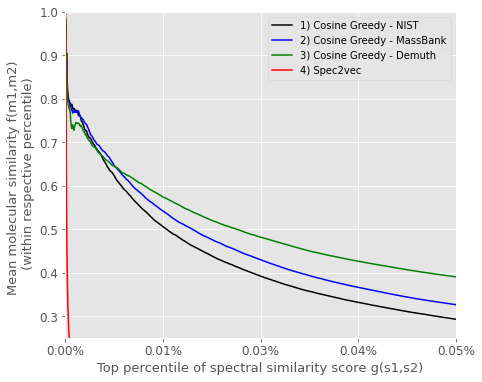

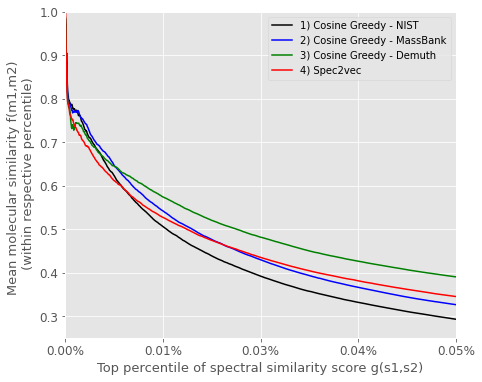

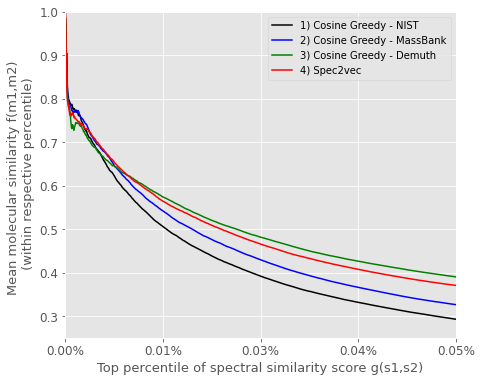

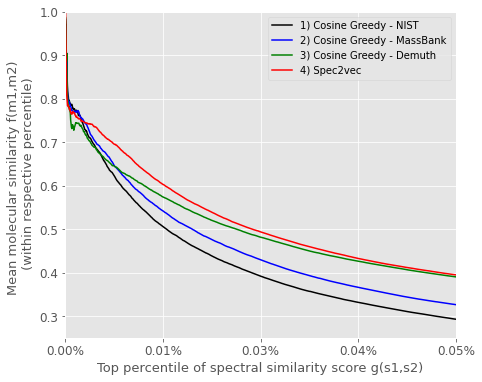

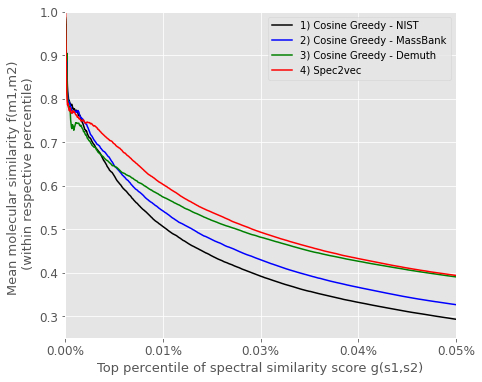

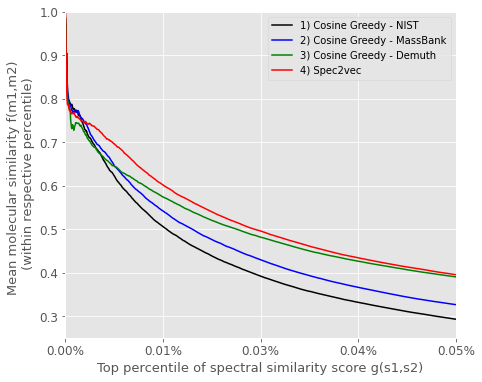

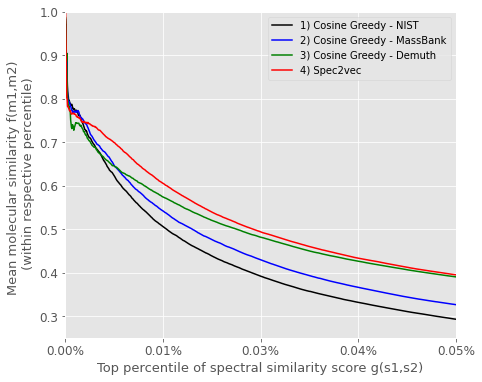

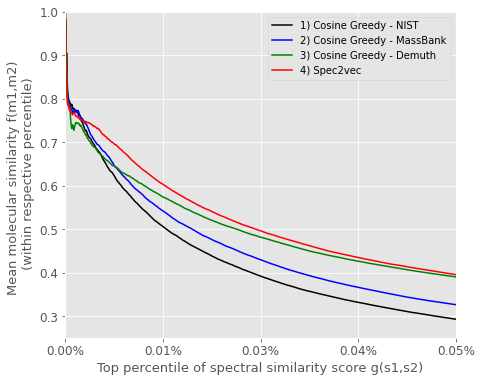

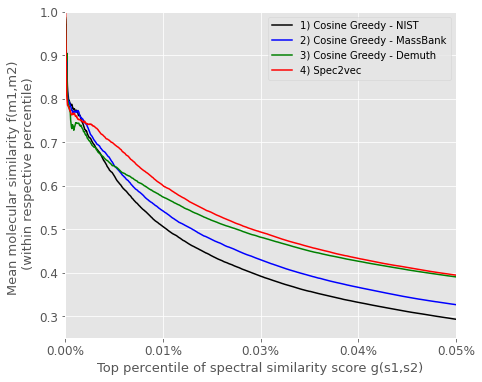

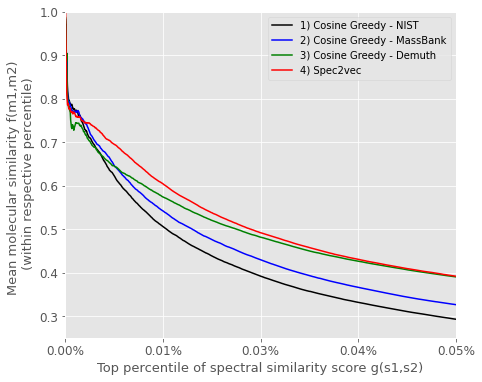

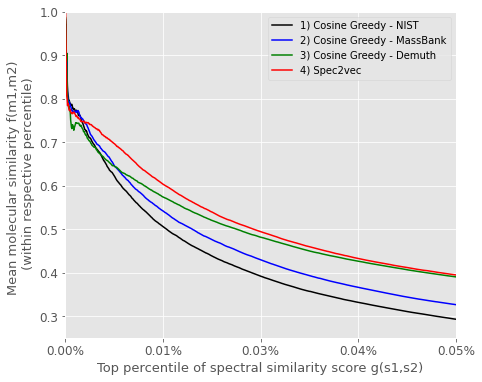

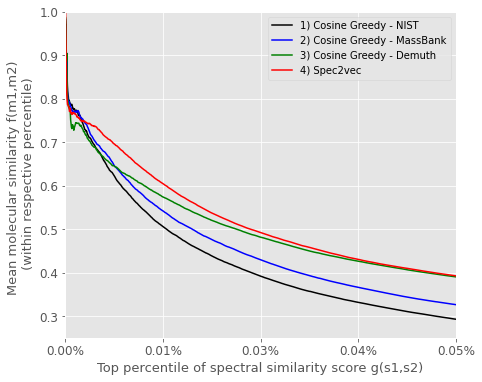

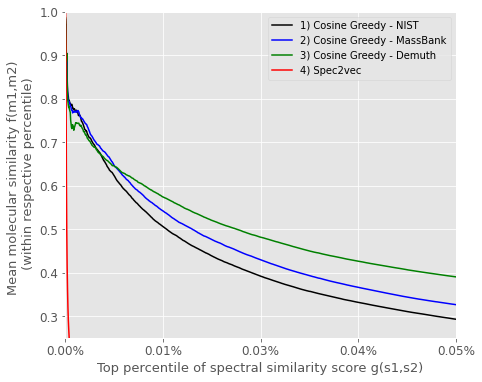

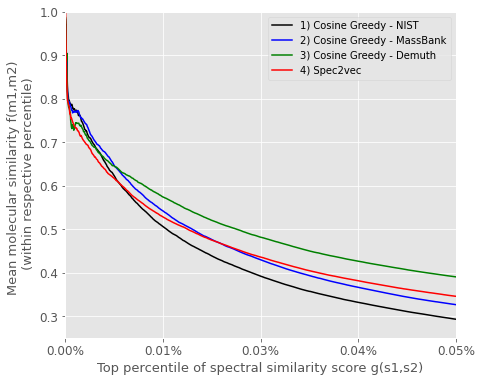

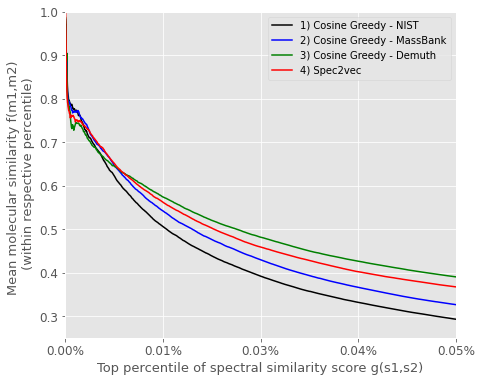

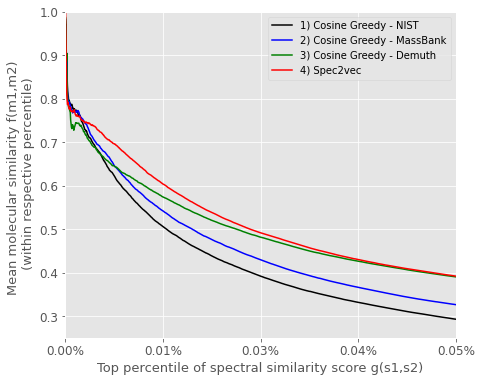

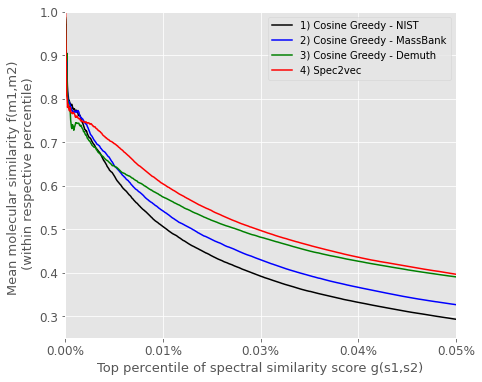

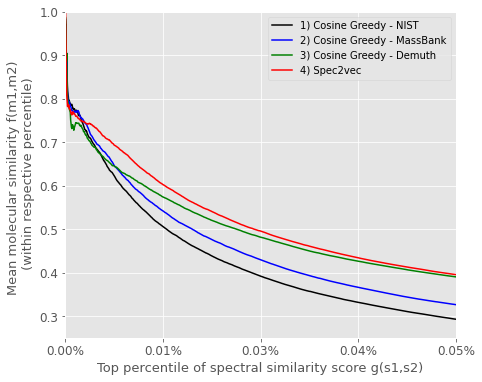

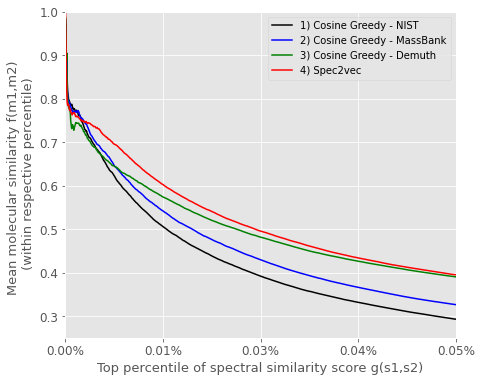

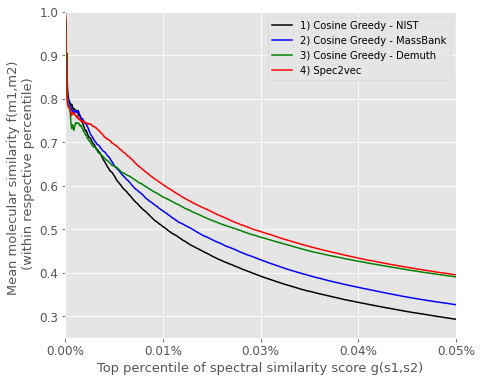

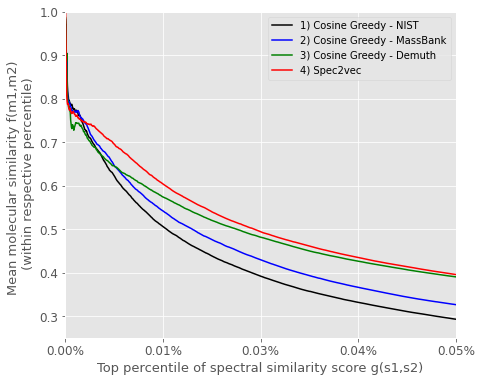

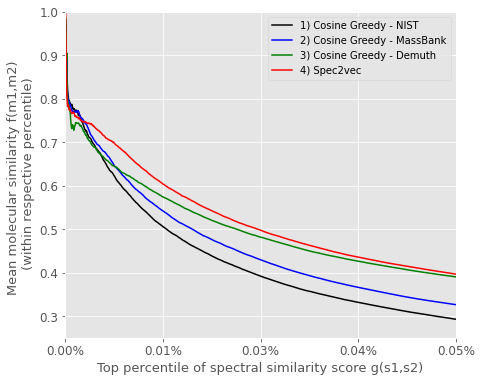

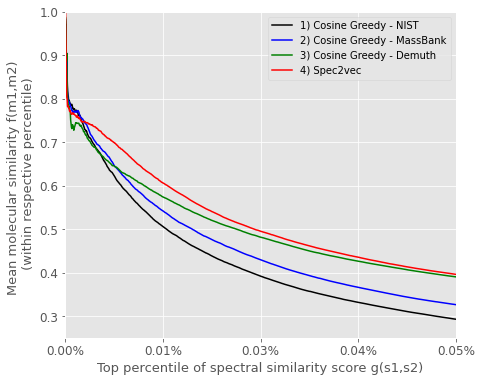

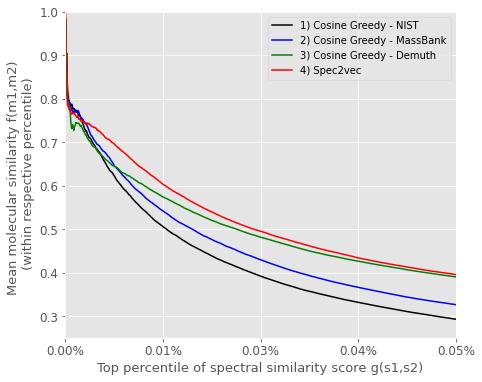

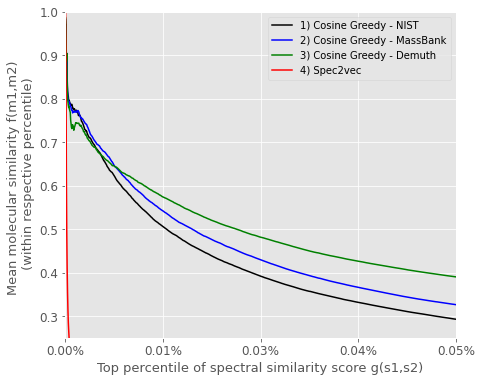

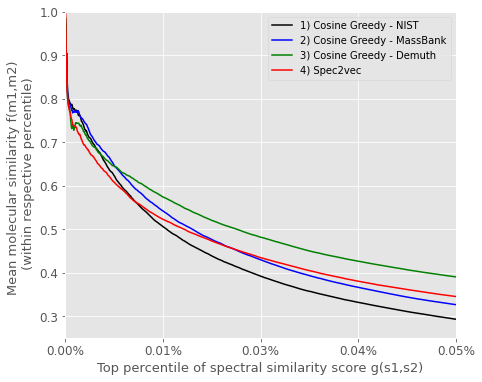

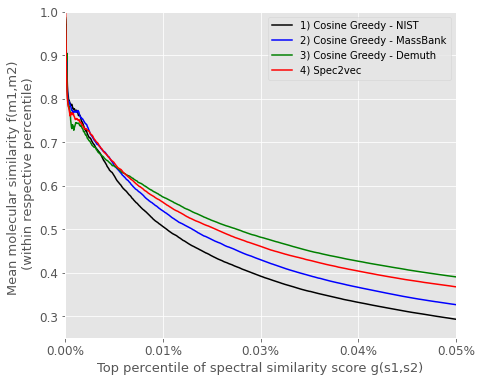

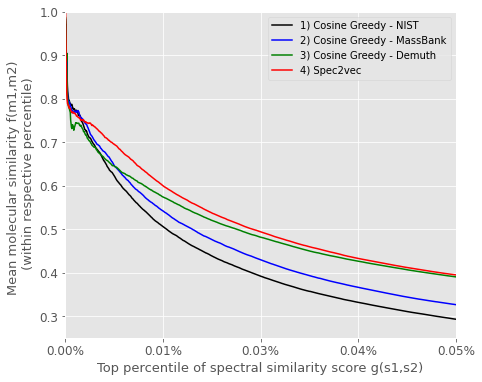

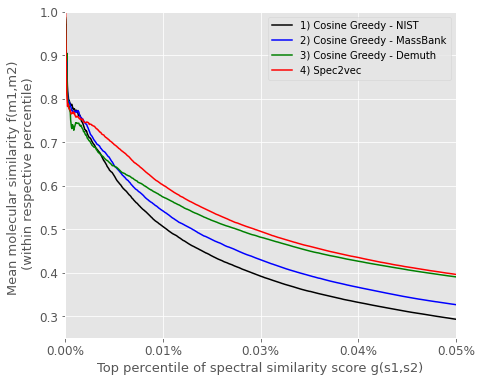

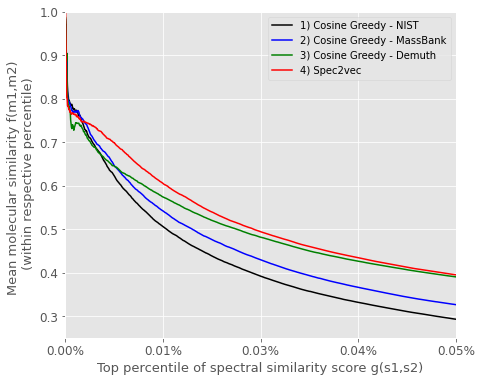

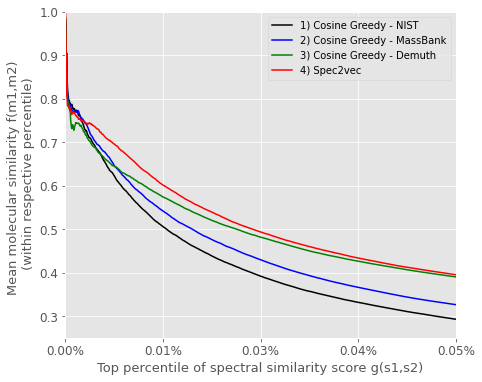

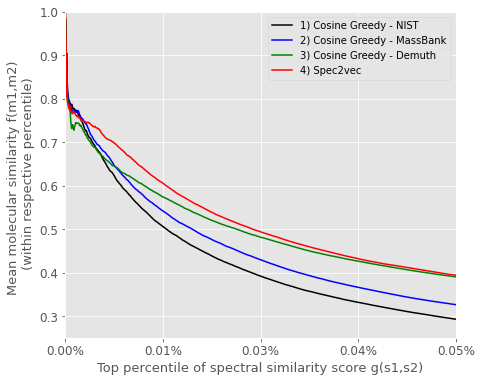

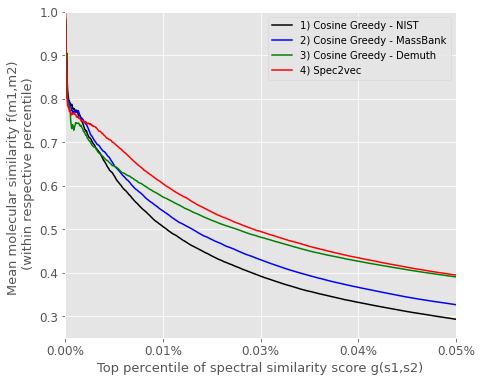

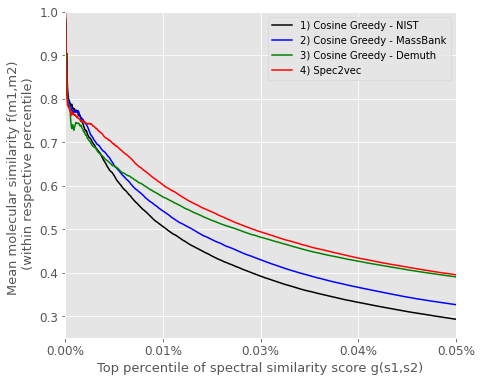

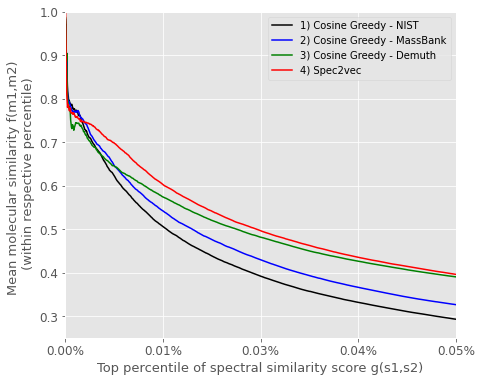

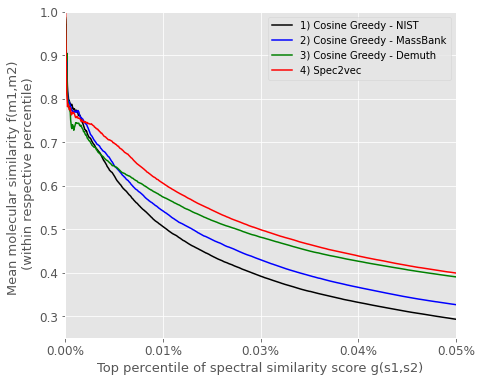

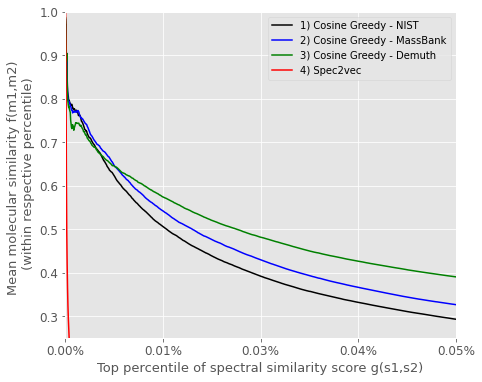

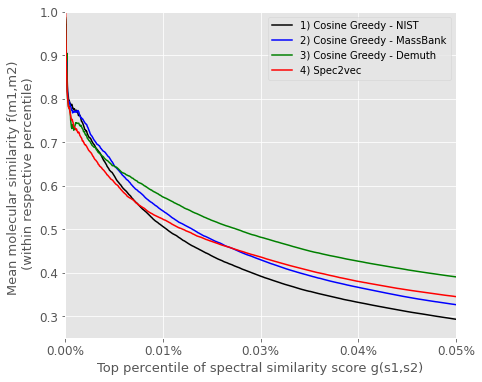

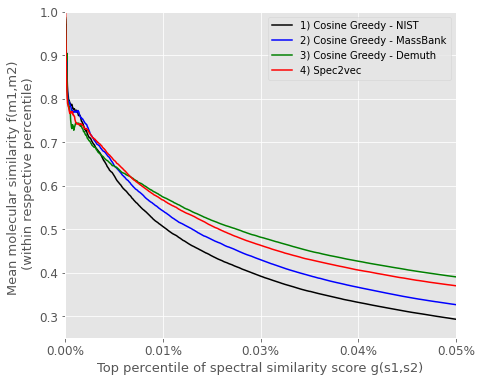

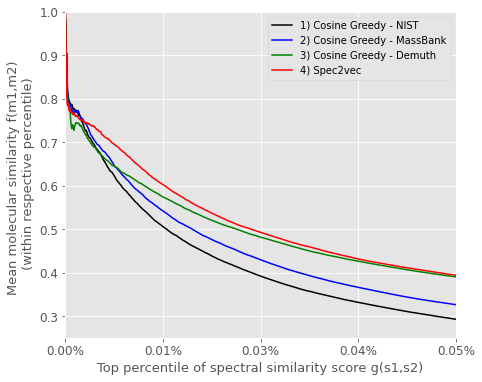

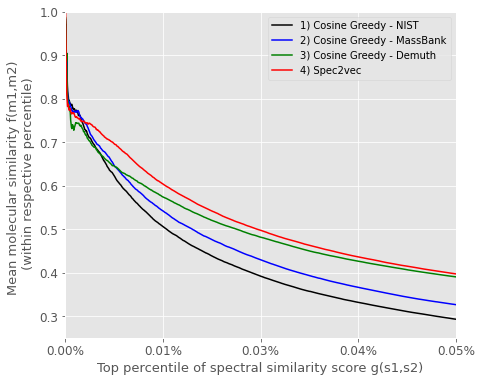

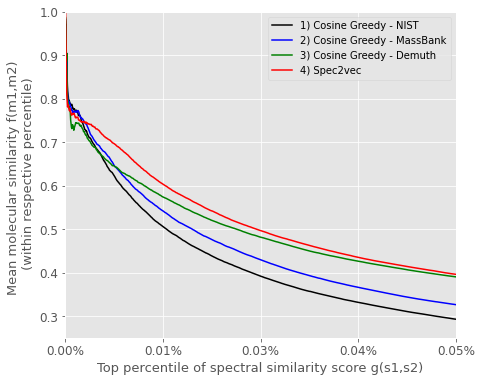

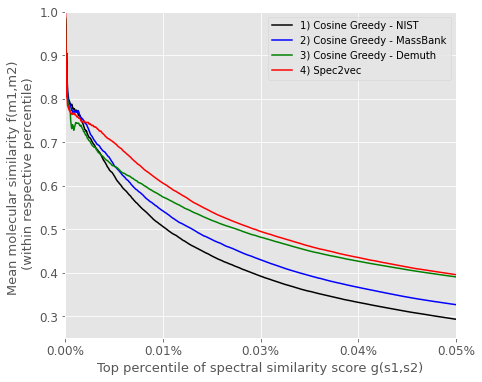

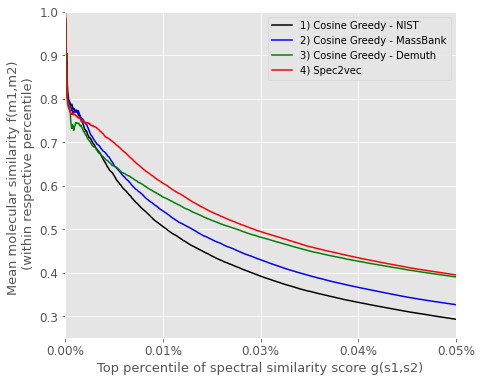

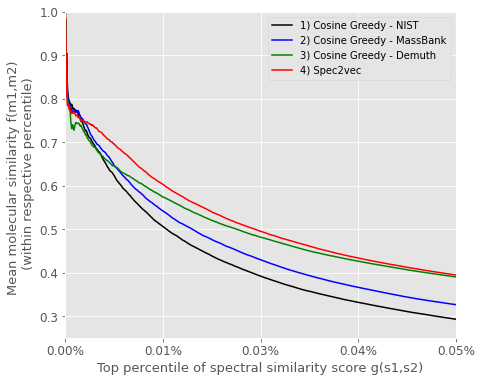

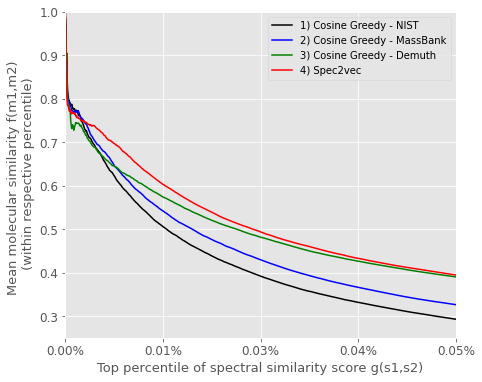

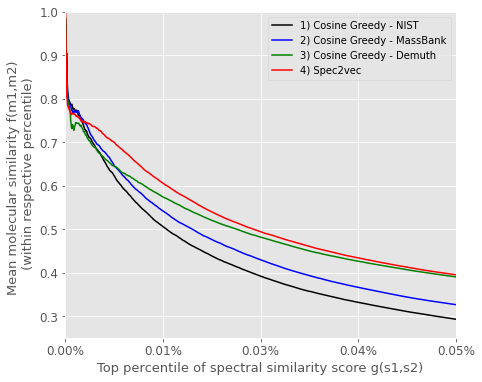

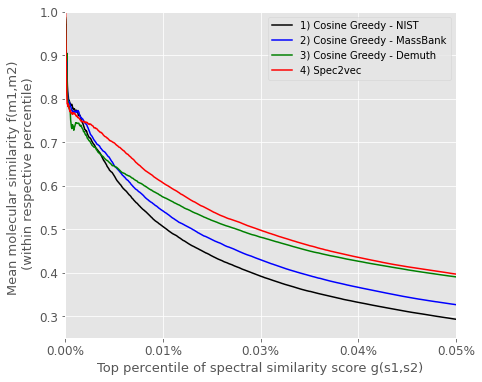

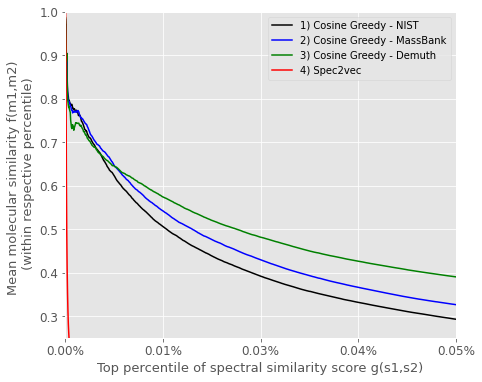

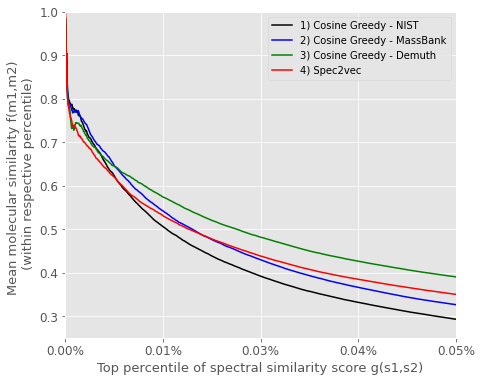

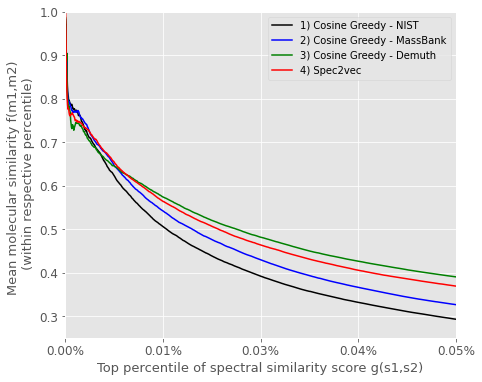

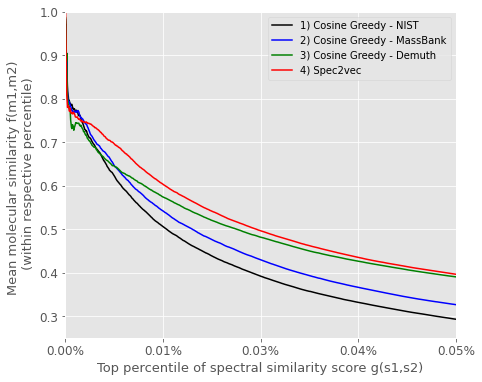

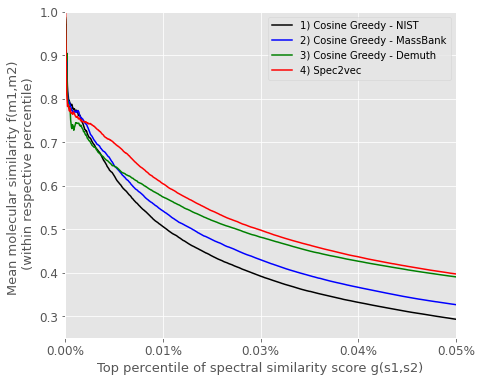

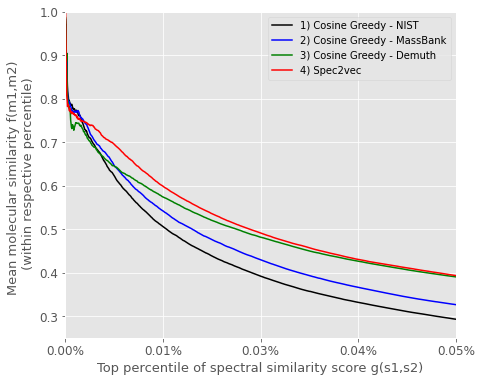

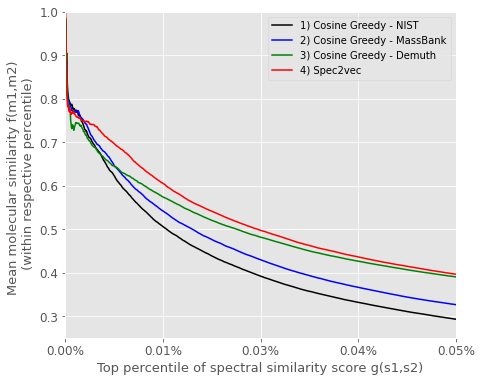

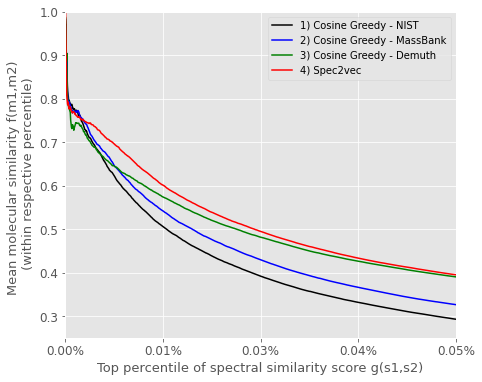

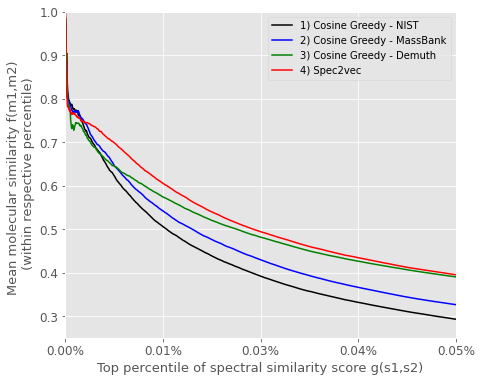

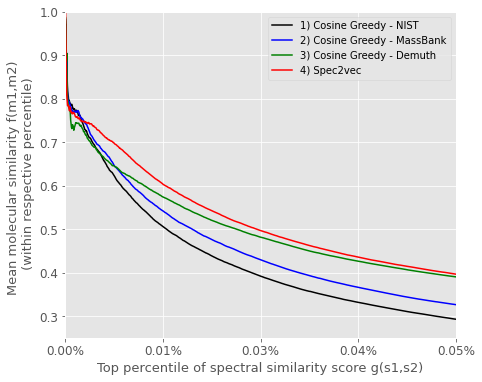

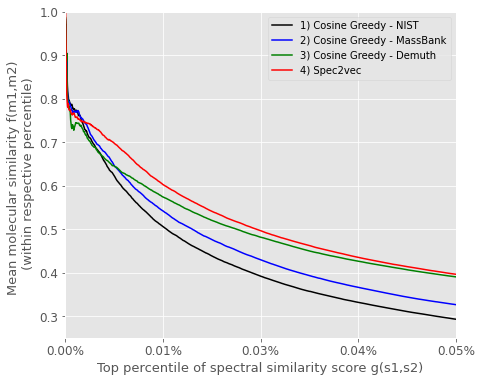

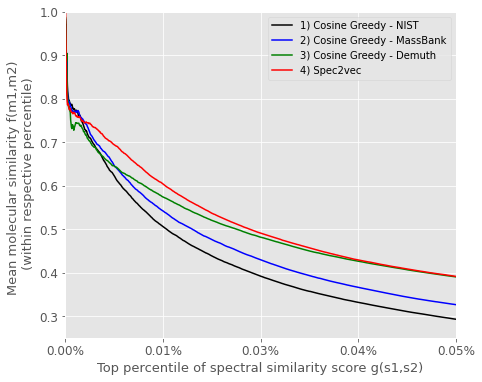

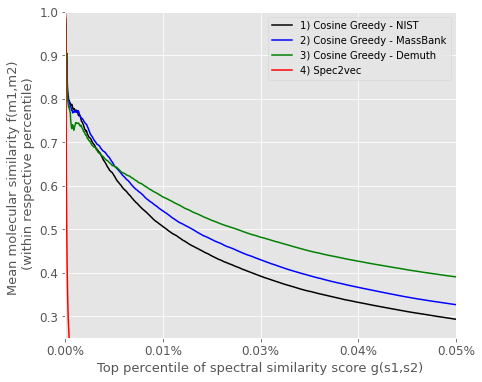

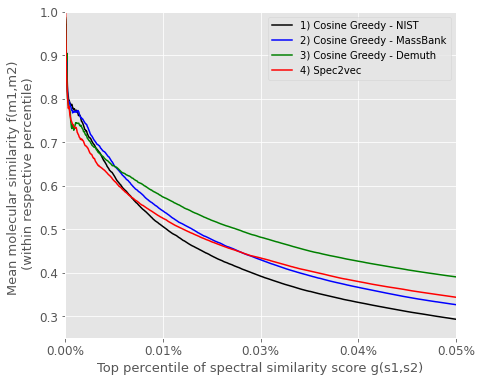

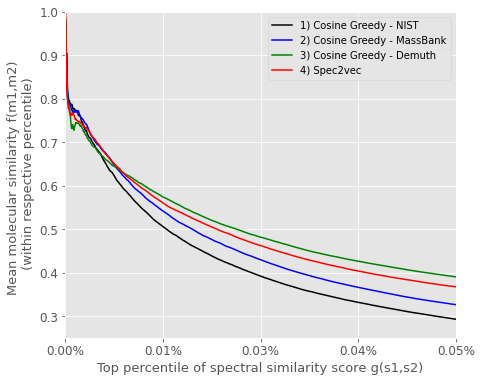

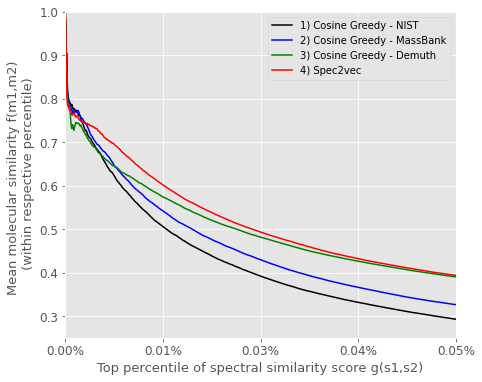

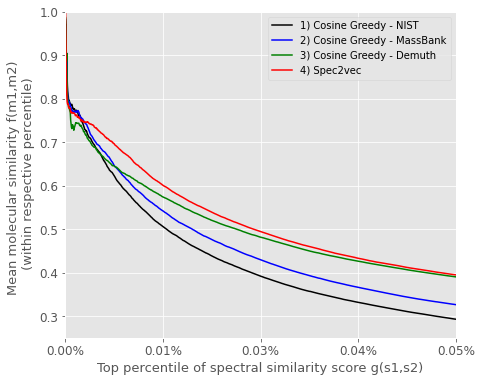

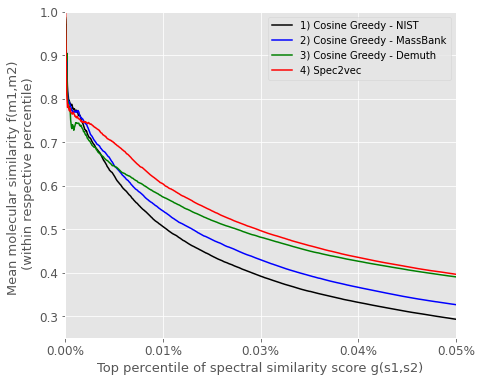

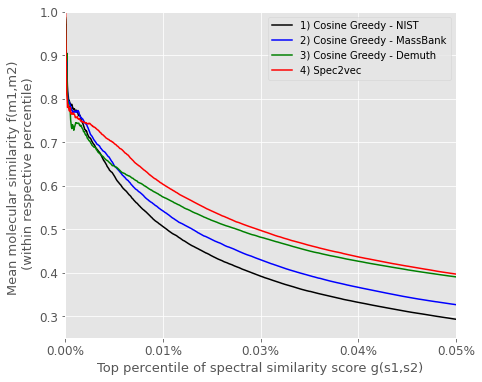

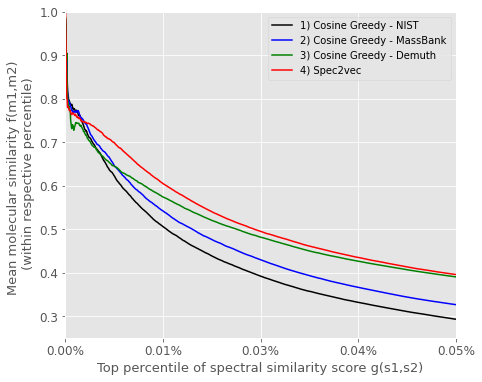

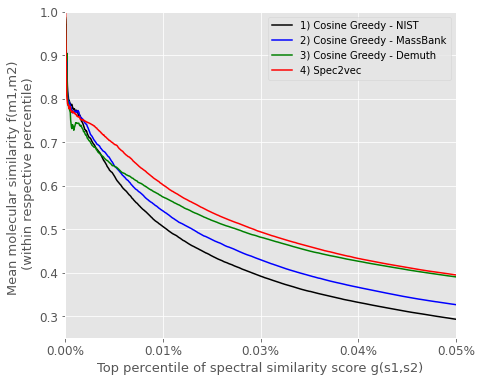

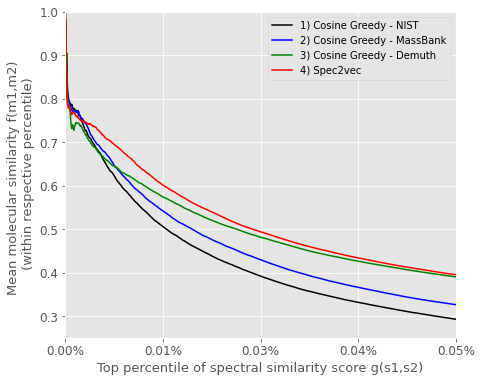

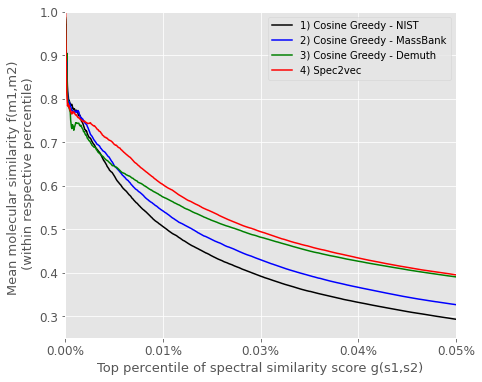

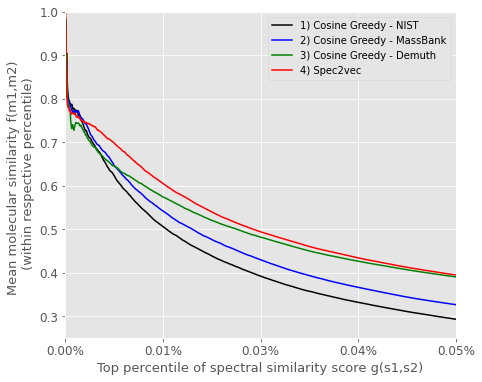

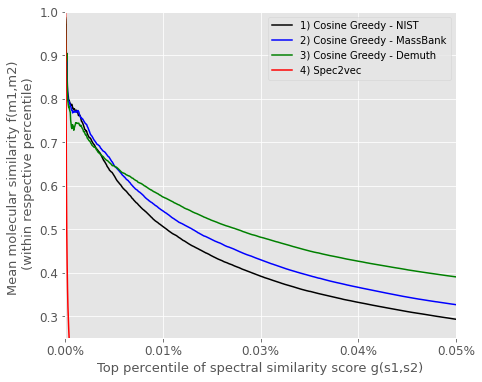

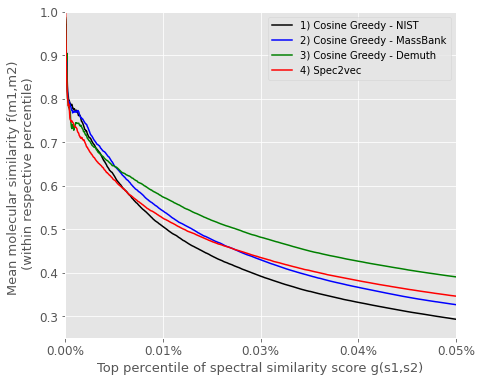

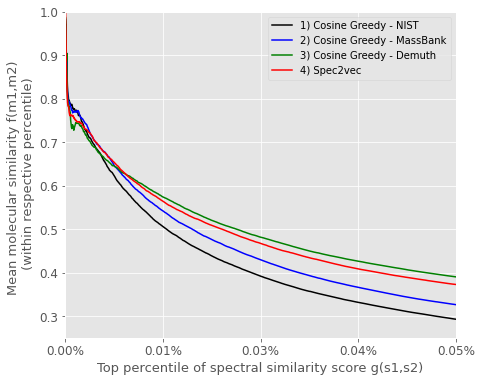

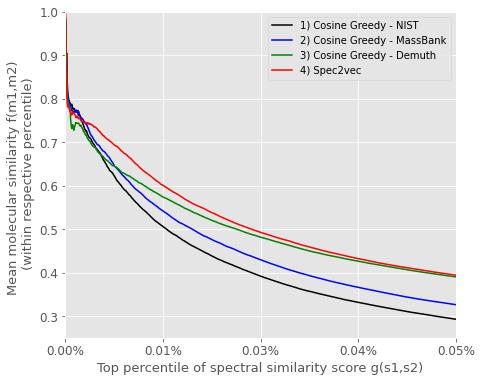

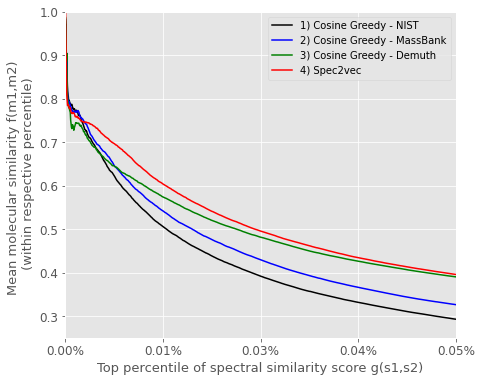

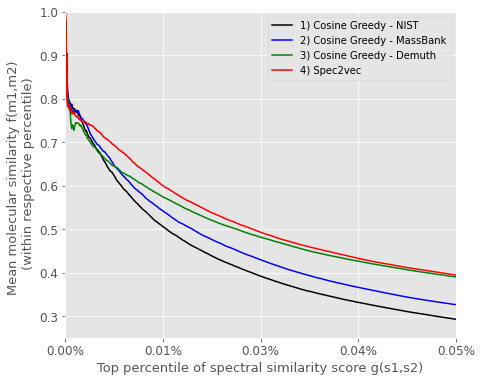

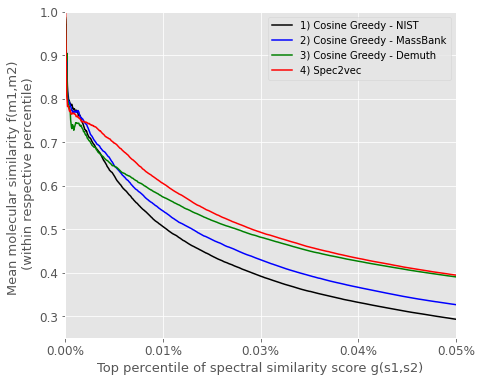

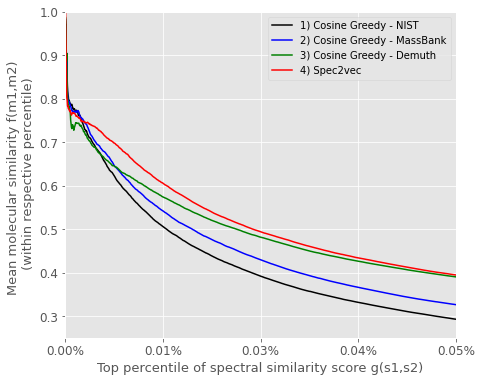

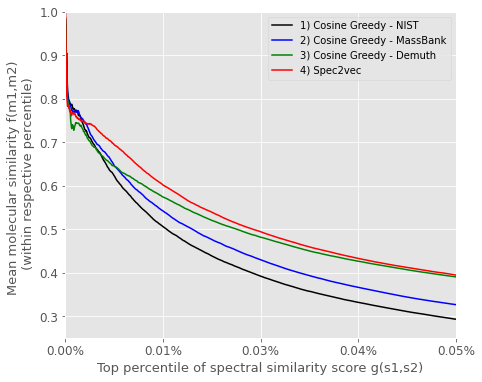

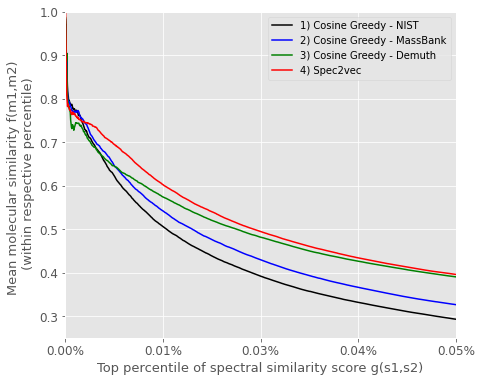

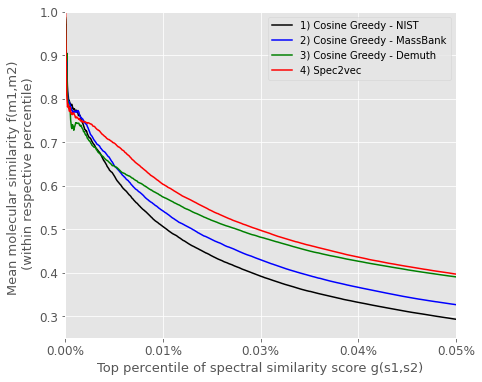

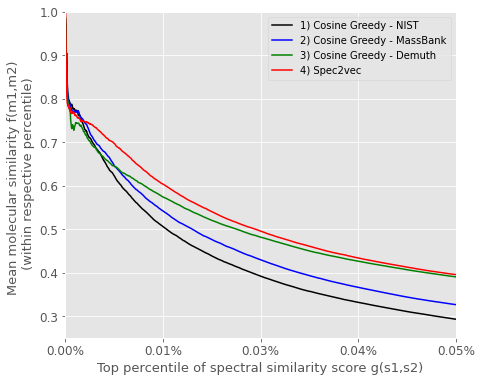

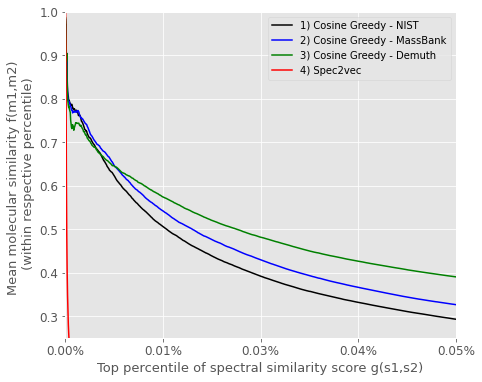

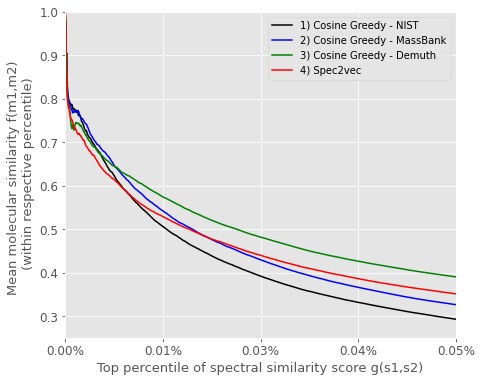

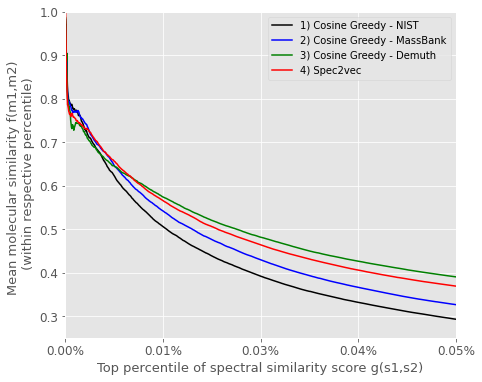

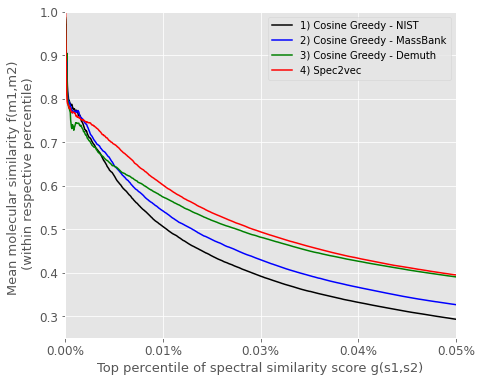

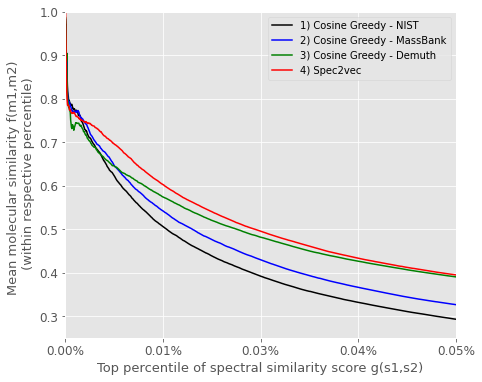

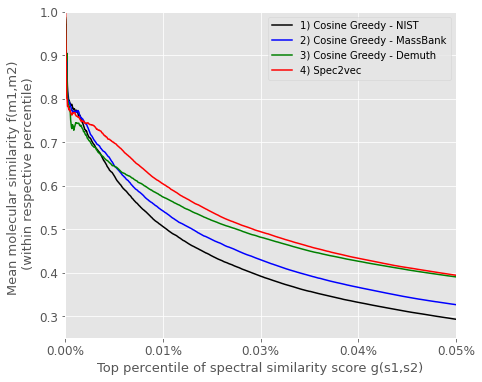

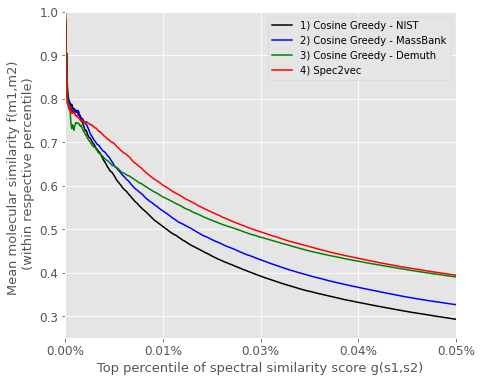

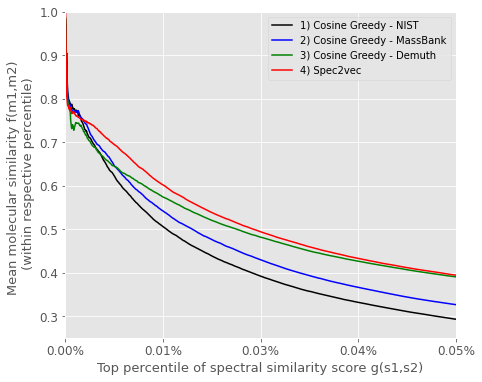

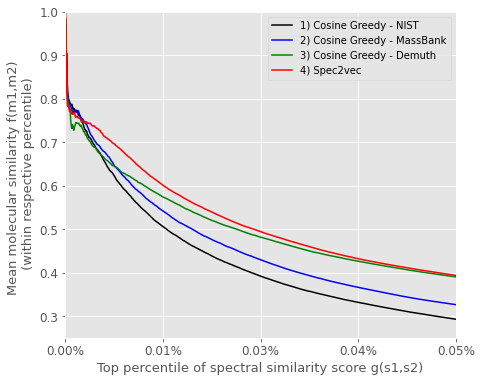

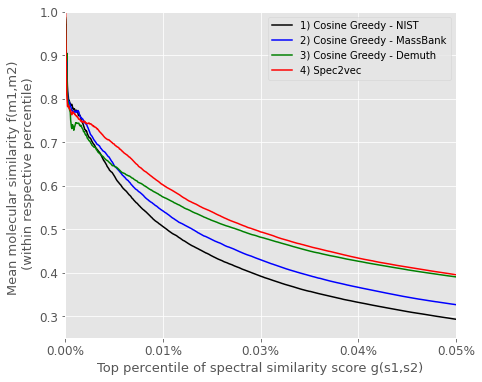

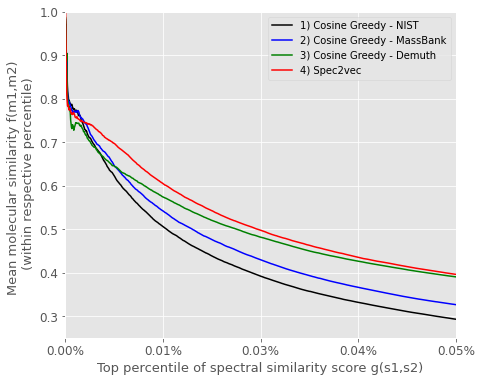

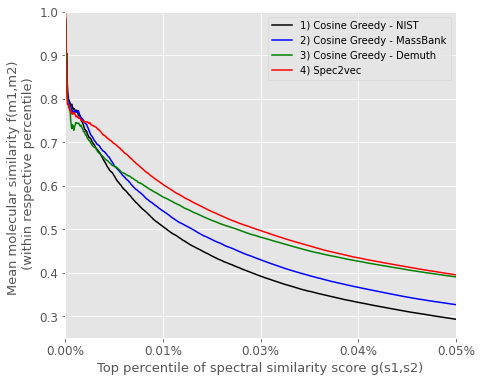

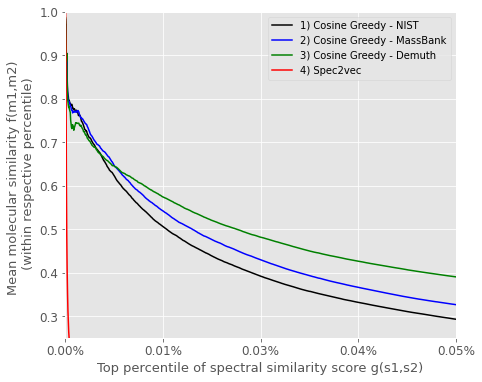

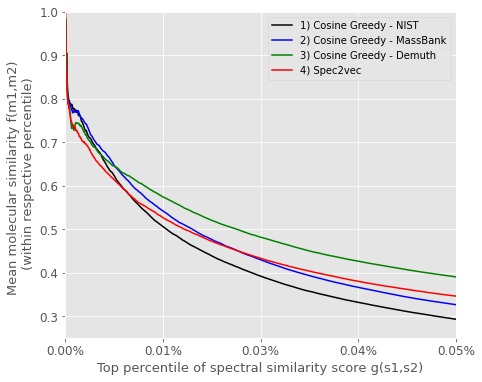

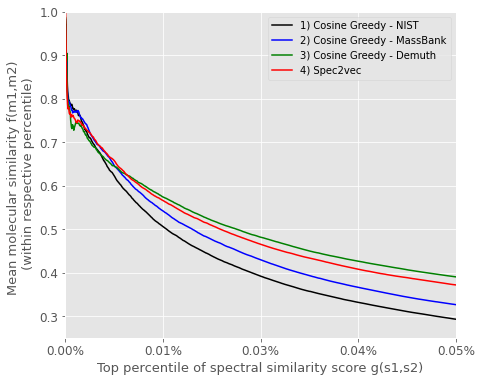

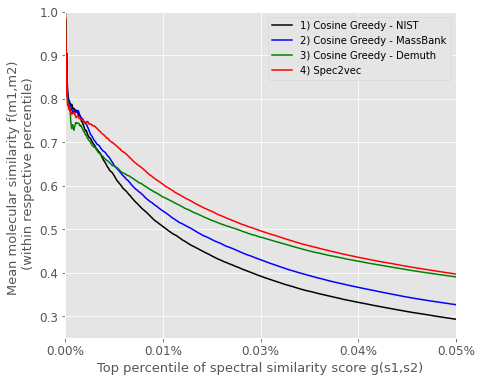

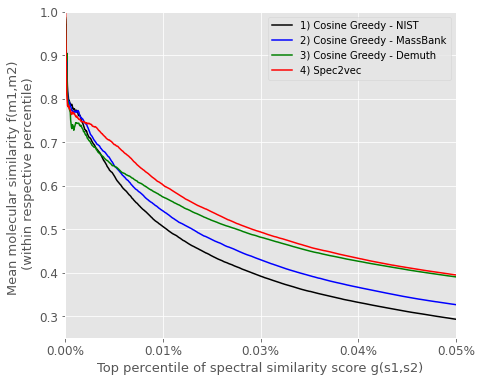

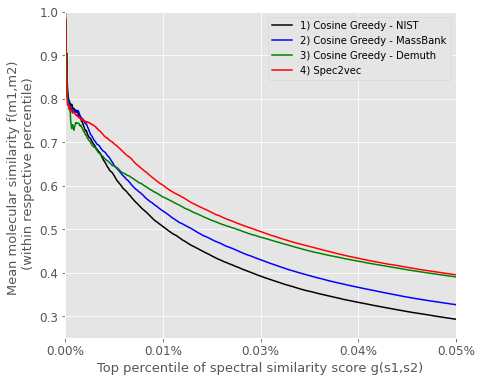

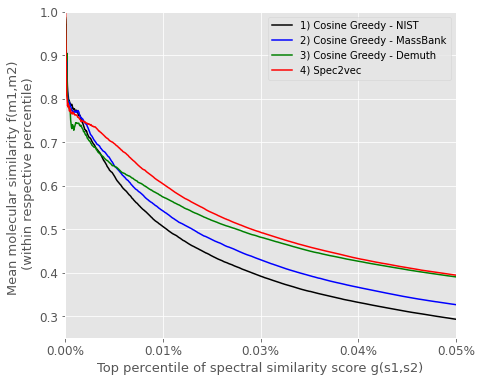

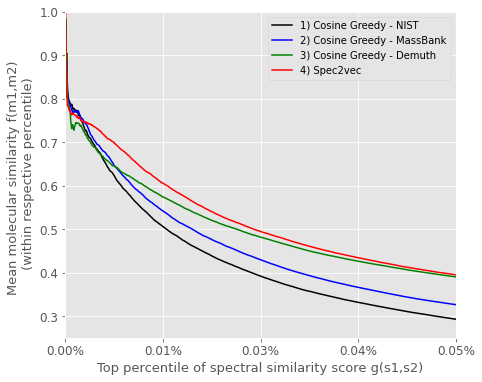

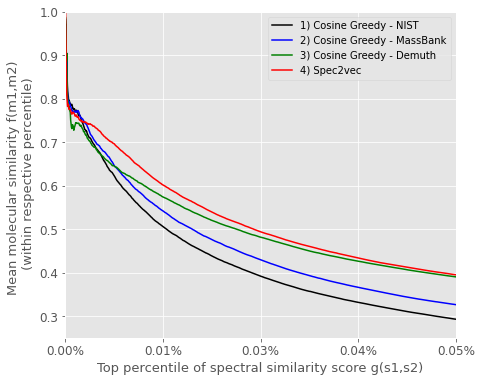

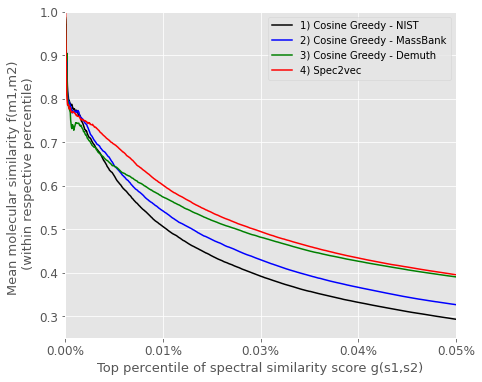

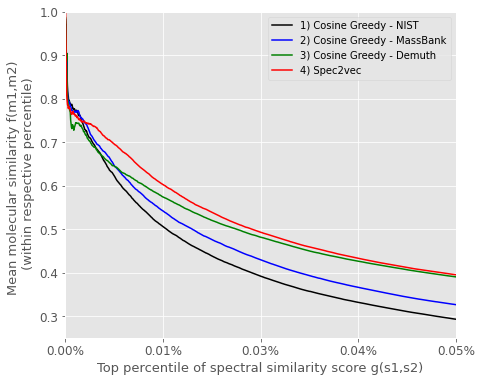

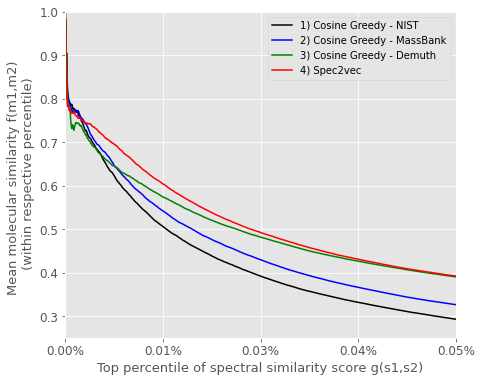

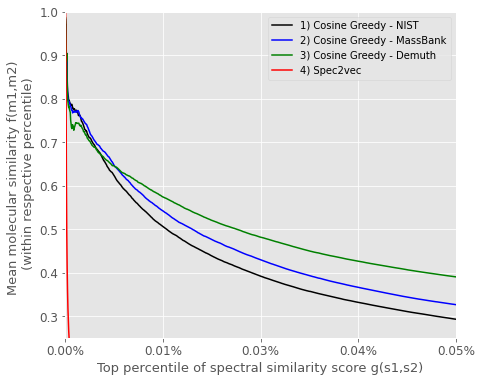

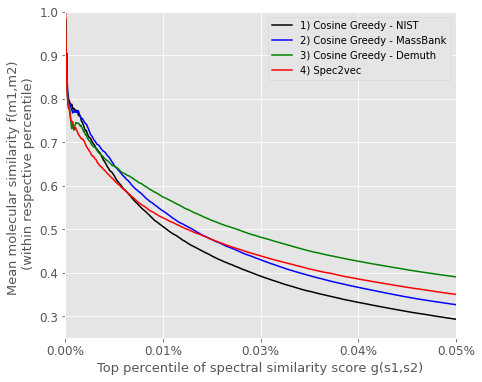

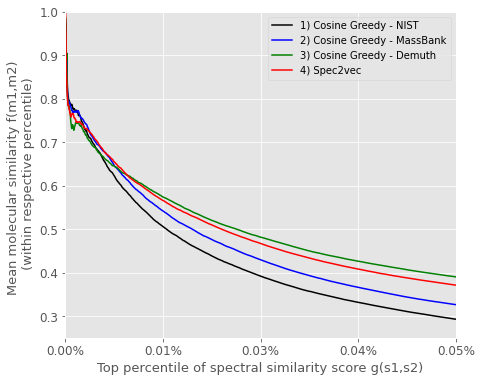

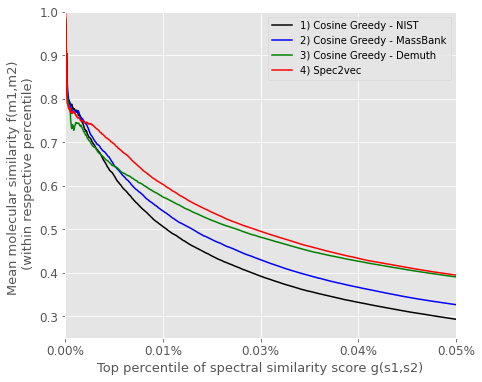

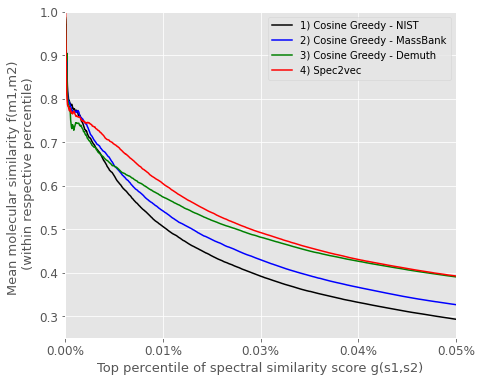

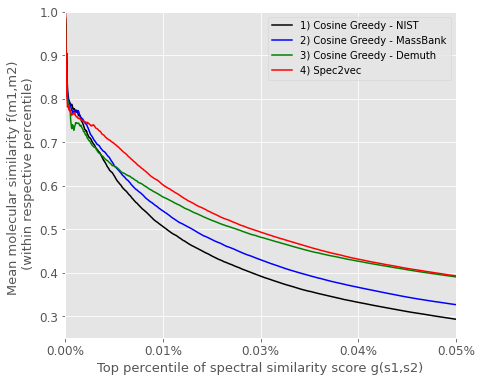

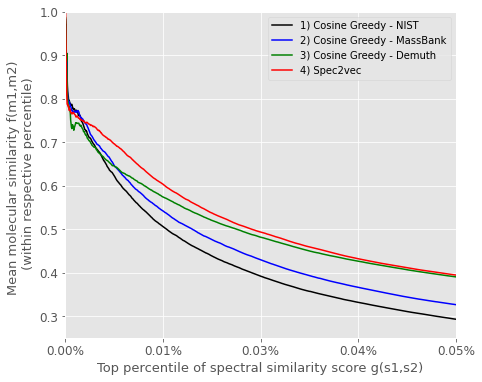

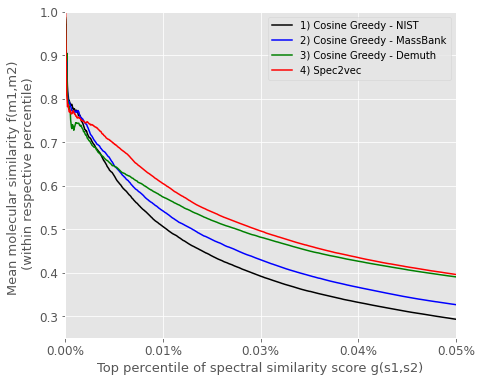

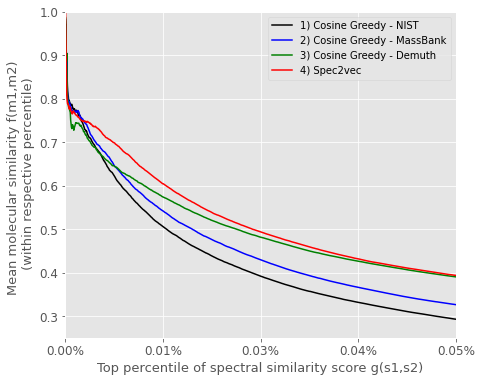

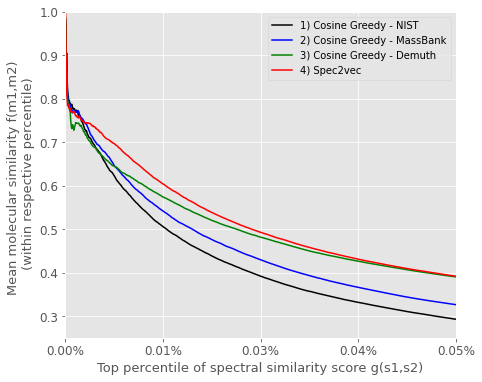

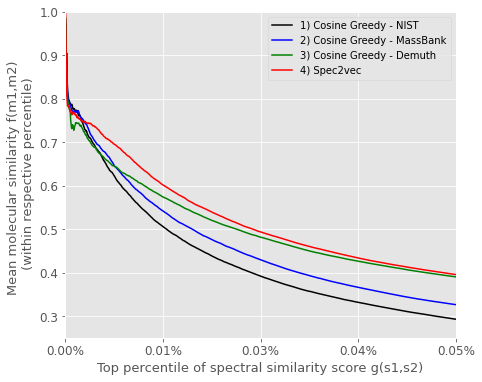

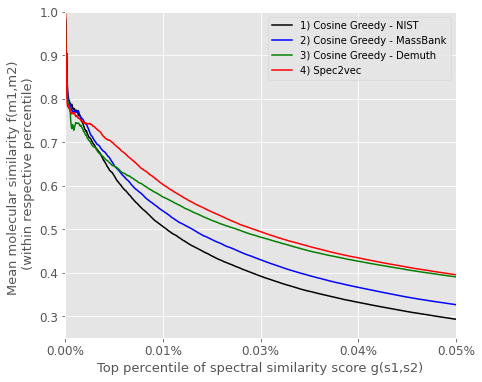

In [14]:
import gensim
from datetime import datetime
from matchms import calculate_scores_parallel
from spec2vec import Spec2VecParallel
from spec2vec.model_building import train_new_word2vec_model

dimensions = [2, 50, 100, 300, 500, 600, 650, 700, 750, 800, 1000, 1200]

iterations_length = len(dimensions) * 10
count = 0

def get_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    current_time = "Time = " + current_time
    return current_time

print("Started at: " + str(get_time()))

for idx in range(10):
    print("Iteration " + str(idx+1))

    for dimension in dimensions:
        
        model_name = "references-it{:d}-d{:d}.model".format(idx+1, dimension)
        model_file = os.path.join(path, model_name)
        model = train_new_word2vec_model(documents=reference_documents, filename=model_file, 
                                         size=dimension, iterations=[10, 20, 30],
                                         workers=2, progress_logger=False)

        model = gensim.models.Word2Vec.load(model_file)

        # Define similarity_function
        spec2vec = Spec2VecParallel(model=model, intensity_weighting_power=0.5,
                                    allowed_missing_percentage=5.0)

        matrix_similarities_spec2vec = []
        matrix_similarities_spec2vec = spec2vec(reference_documents, query_documents)
        
        filename = os.path.join(path, 'similarities_filter05_spec2vec_it' + str(idx+1) + '_size' + str(dimension) + '.npy')
        np.save(filename, matrix_similarities_spec2vec)
        
        # consider creaate code to save the matrix to the hard drive
        percentile_cosine_spec2vec = plot_precentile(matrix_similarities_tanimoto, matrix_similarities_spec2vec, show_top_percentile=show_top_percentile, ignore_diagonal=True)
        
        count += 1
        print("\r", "About {:.3f}% completed".format(100 * count/iterations_length), get_time(), end="\n")
        
        filename = 'spec2vec_performance_it{:d}_size{:d}'.format(idx+1, dimension)
        plot_similarity_algorithms_performance(show_top_percentile, percentile_cosine_nist, percentile_cosine_massbank, percentile_cosine_demuth, percentile_cosine_spec2vec, filename)
        
print("Finished at: " + str(get_time()))